In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import pandas as pd
import csv
from scipy import stats

# pour "jeje":
file="/Users/jeje/Documents/Scolaire/M2/Projet_DFE/doi_10/All_data/data_microMA/dataset_microMA_MutH.csv"
# pour "nana":
#file="../doi_10/All_data/data_microMA/dataset_microMA_MutH.csv"


In [3]:
from IPython.display import display, HTML
CSS = """.output {align-items: center;}"""
HTML('<style>{}</style>'.format(CSS))

# Réécriture Pandas/Numpy

In [4]:
wt_real_df = pd.read_csv(file, 
                      sep = ";", 
                      decimal=",", 
                      usecols=range(2,1476*3+1,3), 
                      skiprows=[1,2])
wt_real_df.iloc[:5, :5]

,growth.rate,growth.rate.1,growth.rate.2,growth.rate.3,growth.rate.4
0,0.03527,0.032026,0.028119,0.029765,NaN
1,0.03527,0.032026,0.028119,0.029765,0.033812
2,0.03247,0.032026,0.026802,0.030567,0.033812
3,0.03247,0.032026,0.026802,0.030567,0.033812
4,0.03247,0.033672,0.026802,0.030567,0.033812


In [5]:
wt_real_array = wt_real_df.to_numpy()

In [6]:
exp_shape = np.shape(wt_real_array)
print(exp_shape)

(1000, 1476)


In [7]:
wt_real_array

array([[3.5269650e-02, 3.2025912e-02, 2.8119496e-02, ..., 2.3454689e-02,
        1.8758796e-02,           nan],
       [3.5269650e-02, 3.2025912e-02, 2.8119496e-02, ..., 2.3454689e-02,
        1.8758796e-02, 2.5567243e-02],
       [3.2470449e-02, 3.2025912e-02, 2.6801815e-02, ..., 2.6620318e-02,
        3.0876094e-02, 2.5567243e-02],
       ...,
       [2.8670487e-02, 1.6752654e-02, 2.5671465e-02, ..., 4.7900000e-05,
        2.6452291e-02, 0.0000000e+00],
       [2.8670487e-02, 1.6752654e-02, 2.5671465e-02, ..., 4.7900000e-05,
        2.6452291e-02, 0.0000000e+00],
       [2.8670487e-02, 1.6752654e-02, 2.5671465e-02, ..., 4.7900000e-05,
        2.6452291e-02, 0.0000000e+00]])

In [8]:
# Distribution initiale des taux de croissances
#wt_init = wt_real_array[:,0]   # première génération de l'expérience (comprenant des taux de croissance aberrants et des NAs)
wt_init = np.array([np.median([l for l in d if not np.isnan(l)]) for d in wt_real_array.T[:,:10]])   # médiane des 10 premières mesures
wt_init[wt_init<0] = 0          # retirer la valeur de taux de croissance négative aberrante

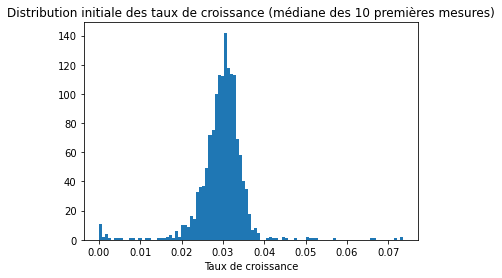

In [9]:
plt.hist(wt_init, bins=100)
plt.title("Distribution initiale des taux de croissance (médiane des 10 premières mesures)")
plt.xlabel("Taux de croissance")
plt.show()

# Simulation réaliste

- Paramètres utilisés pour la simulation

In [10]:
# Générer des mutations
mutation_rate = 0.32/60   # nombre de mutations par minute, estimation pour mutH (mutH: ~0.32 mutation/heure)
exp_duration = 4000       # durée de l'expérience, en minutes
mut_shape = (int(exp_duration*mutation_rate*3), 1476)  # nombre de mutations à tirer dans chacun des 1476 canaux de l'expérience
lethal_mut_proba = 0.01   # fraction de mutation létales (estimée à 1% dans l'article)
constant_mut_rate = False # on choisit si le taux de mutation est constant


# Temps de mesure des taux de croissance, comme dans l'article (toutes les 4 minutes sur 4000 minutes)
time = np.arange(0, 4000, 4, dtype=float)

- Tirer dans une DFE donnée l'effet relatif de chacune des mutations sur le taux de croissance

In [11]:

# Paramètres de la distribution Beta fittée comme DFE dans l'article
#alpha1=0.0025
#beta1=2.4
alpha1=0.04
beta1=2
alpha2=0.004
beta2=2

esp1=alpha1/(alpha1+beta1)
esp2=alpha2/(alpha2+beta2)
var1=alpha1*beta1/((alpha1+beta1)**2*(alpha1+beta1+1))
var2=alpha2*beta2/((alpha2+beta2)**2*(alpha2+beta2+1))
asym1=2*(beta1-alpha1)*np.sqrt(alpha1+beta1+1)/((alpha1+beta1+2)*np.sqrt(alpha1*beta1))
asym2=2*(beta2-alpha2)*np.sqrt(alpha2+beta2+1)/((alpha2+beta2+2)*np.sqrt(alpha2*beta2))


print("Espérance de la loi simulée:",esp1+esp2)
print("Espérance à obtenir: 0.002")
print("CV de la loi simulée:",np.sqrt(var1+var2)/(esp1+esp2))
print("CV à obtenir: 9.4")
print("Asymétrie de la loi simulée:",asym1+asym2)
print("Asymétrie à obtenir: 24")

Espérance de la loi simulée: 0.02160385112128684
Espérance à obtenir: 0.002
CV de la loi simulée: 3.8690277619504223
CV à obtenir: 9.4
Asymétrie de la loi simulée: 25.301059580282804
Asymétrie à obtenir: 24


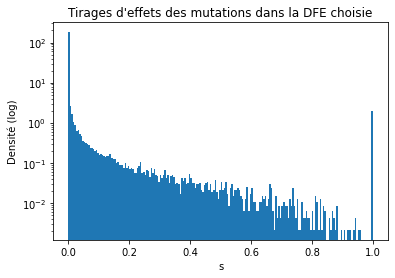

In [12]:
np.random.seed(0)    # graîne pour les générateurs aléatoires

# Combiner différentes densités pour former une DFE mixte
#dty_mix = (np.random.beta(alpha, beta, mut_shape),           # distribution beta inférée dans l'article
#           np.ones(mut_shape))                               # mutations létales
dty_mix = (np.random.beta(alpha1,beta1, mut_shape),
           np.random.beta(alpha2,beta2, mut_shape),
           np.ones(mut_shape))                               

#weights = np.array([1-lethal_mut_proba, lethal_mut_proba])   # poids de chaque densité
weights = np.array([(1-lethal_mut_proba)/2,(1-lethal_mut_proba)/2, lethal_mut_proba])   # poids de chaque densité

s = np.choose(np.random.choice(np.arange(len(dty_mix)), p=weights, size=mut_shape), choices = dty_mix)

plt.hist(np.concatenate(s), bins=200, log=True, density=True)
plt.title("Tirages d'effets des mutations dans la DFE choisie")
plt.xlabel("s")
plt.ylabel("Densité (log)")
plt.show()

In [13]:
# Effets relatifs des mutations sur la fitness
fitness_effects = (1 - s)
fitness_effects

array([[0.99999466, 0.99999726, 0.82362285, ..., 0.91179915, 1.        ,
        1.        ],
       [1.        , 0.99980835, 1.        , ..., 1.        , 1.        ,
        0.99999996],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.99999993],
       ...,
       [0.91239671, 0.99982277, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.99999939,
        0.99935247],
       [1.        , 0.99985256, 0.99999995, ..., 1.        , 1.        ,
        0.99999873]])

$\to$ Attention aux approximations numériques : suppression de la plupart des mutations les plus faibles (ne devrait pas être un problème)

- Simuler l'évolution du taux de croissance après chaque mutation

In [14]:
cumulative_fitness_effects = np.cumprod(fitness_effects, axis=0)    # effets relatifs cumulés des mutations
wt_steps_sim = np.vstack((wt_init, cumulative_fitness_effects*wt_init))    # évolution du taux de croissance mutation par mutation

wt_steps_sim

array([[0.03247045, 0.03284871, 0.0281195 , ..., 0.02662032, 0.02952523,
        0.02556724],
       [0.03247028, 0.03284862, 0.02315986, ..., 0.02427238, 0.02952523,
        0.02556724],
       [0.03247028, 0.03284233, 0.02315986, ..., 0.02427238, 0.02952523,
        0.02556724],
       ...,
       [0.00987387, 0.02121355, 0.00435079, ..., 0.        , 0.        ,
        0.        ],
       [0.00987387, 0.02121355, 0.00435079, ..., 0.        , 0.        ,
        0.        ],
       [0.00987387, 0.02121042, 0.00435079, ..., 0.        , 0.        ,
        0.        ]])

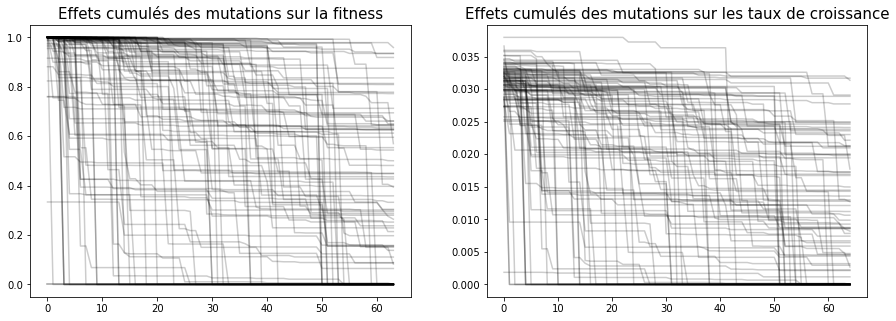

In [15]:
im,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(cumulative_fitness_effects[:,:100], color="black", alpha=0.2)
ax1.set_title("Effets cumulés des mutations sur la fitness",fontsize=15)
ax2.plot(wt_steps_sim[:,:100], color="black", alpha=0.2)
ax2.set_title("Effets cumulés des mutations sur les taux de croissance",fontsize=15)
plt.show()

- Tirer des intervalles exponentiels entre 2 mutations pour chacun des 1476 canaux, de manière à largement dépasser les 4000 heures de l'expérience en cumulé.

In [16]:
np.random.seed(0)

if constant_mut_rate : # taux de mutation constant dans le temps et entre les cellules
    exponential_intervals = np.random.exponential(1/mutation_rate, mut_shape)  # durées entre 2 mutations
    #print(exponential_intervals)
else :                 # taux de mutation décroissant avec le taux de croissance (cycle cellulaire et réplication ralentis)
    mutation_rate_t = wt_steps_sim[:-1]/np.mean(wt_init) * mutation_rate
    exponential_intervals = np.random.exponential(1/mutation_rate_t)
    exponential_intervals[np.isinf(exponential_intervals)] = exp_duration

mutation_time = np.cumsum(exponential_intervals, axis=0)  # temps d'apparition de chaque mutation, en minutes
print(np.shape(mutation_time))

#plt.hist(mutation_time[-1,:])
#plt.vlines(exp_duration, 0, 300, colors="red", linestyles="dashed")
#plt.title("Distribution des durées d'expériences in silico")
#plt.xlabel("Temps (min)")
#plt.show()

# Vérifier que toutes les expériences in silico sont plus longues que l'expérience réelle, pour pouvoir tronquer
assert min(mutation_time[-1,:]) > exp_duration, "Add more mutations, simulations trop courtes : " + str(mutation_time[-1,mutation_time[-1,:]<exp_duration])

(64, 1476)


/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


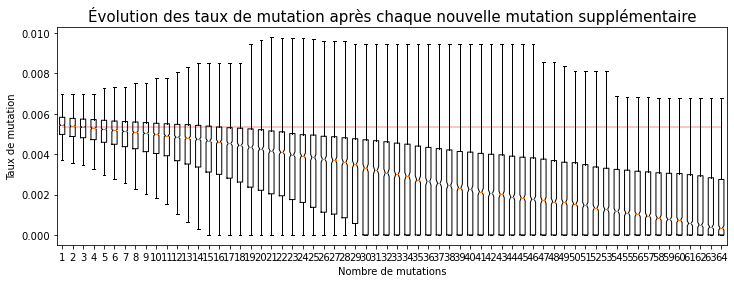

In [17]:
im, ax = plt.subplots(1,1,figsize=(12,4))
ax.hlines(y = mutation_rate, xmin = 1, xmax = np.shape(mutation_rate_t)[0], alpha=0.3, color="red")
ax.boxplot(mutation_rate_t.T, notch=True, sym="")
ax.set_title("Évolution des taux de mutation après chaque nouvelle mutation supplémentaire",fontsize=15)
ax.set(xlabel="Nombre de mutations", ylabel="Taux de mutation")
plt.show()

- Combiner l'évolution du taux de croissance mutation par mutation et les intervalles entre 2 mutations pour obtenir la véritable évolution des taux de croissance

In [18]:
wt_sim = []
for i in range (0, np.shape(mutation_time)[1]):  # pour chaque expérience
    # Identifier après quelle mutation la mesure est faite
    cond = np.array([time<t for t in mutation_time[:,i]]) & np.array([time>=t for t in np.concatenate(([0],mutation_time[:-1,i]))])
    # Prendre la valeur de taux de croissance associé à cette mutation
    wt_sim.append(np.piecewise(time, condlist = cond, funclist = wt_steps_sim[1:,i]))

wt_sim = np.array(wt_sim).T

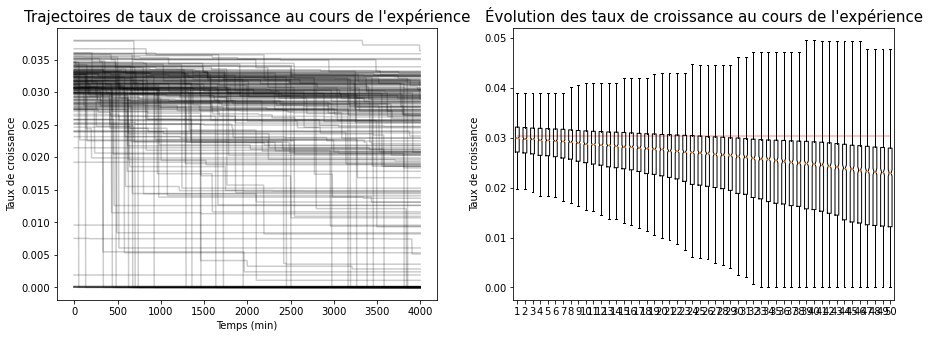

In [19]:
im, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(time, wt_sim[:,:200], color="black", alpha=0.2)
ax[0].set_title("Trajectoires de taux de croissance au cours de l'expérience",fontsize=15)
ax[0].set(xlabel="Temps (min)", ylabel="Taux de croissance")

ax[1].hlines(y = np.median(wt_init), xmin = 1, xmax = np.shape(wt_sim)[0]/20, alpha=0.3, color="red")
ax[1].boxplot(wt_sim.T[:,range(0,np.shape(wt_sim)[0],20)], notch=True, sym="")
ax[1].set_title("Évolution des taux de croissance au cours de l'expérience",fontsize=15)
ax[1].set(ylabel="Taux de croissance")
plt.show()

# Animation

In [20]:
xmin=0
xmax=0.14
ymin=0
ymax=250
nbreaks=200

tmax=1000
#ncells=1475

#lambd=0.1 # paramètre de la loi de Poisson
#Nt=0 # nombre de mutations avant le temps t

#seuil_detection_fitness=0.0005

In [21]:
def get_y(x,wt_cur,eps): # trouve la hauteur de la barre de l'histogramme correspondant à [x-eps/2,x+eps/2]
    y=[]
    i=0
    j=0
    for x_cur in x:
        while x_cur-wt_cur[i]>eps/2 and i<len(wt_cur)-1: i+=1
        while wt_cur[j]-x_cur<eps/2 and j<len(wt_cur)-1: j+=1
        y+=[j-i]
    return y

def get_dist_s(wt_real): # calcul de tous les effets entre chaque mesure (inclut les non-effets en cas de non-division)
    s=[]
    for i in range(2,len(wt_real)-1):
        for j in range(len(wt_real[i])): 
            wv=(wt_real[i])[j]
            wn=(wt_real[i+1])[j]
            if wv!=0:
                s+=[(wv-wn)/wv]
    return s

def sort_rows(w): # pour optimiser la construction de l'histogramme
    res=[]
    for row in w:
        res+=[np.sort(row)]
    return res
    
def analyse_ligne(row): 
    res=[]
    for i in range(int(len(row)/3-1)):
        if(row[3*i+2]!="NA"):
            nouv=float(row[3*i+2].replace(",","."))
            if nouv<seuil_detection_fitness: nouv=0
            res+=[nouv]
        else:
            res+=[0] # JJ   attention, pb à régler un jour!
    return res

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
line1,line2,=ax.plot([], [], [], [])
line = [line1,line2]
ax.legend(["Processus simulé","Processus observé"])
ax.set(xlabel = "Taux de croissance au temps t", ylabel = "Nombre d'individus")
plt.close()

def init():
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid(True)
    return line,

def update(frame): # met à jour l'affichage
    x=np.linspace(xmin,xmax,nbreaks)
    y_sim=get_y(x,np.sort(wt_sim[frame]),eps=(xmax-xmin)/nbreaks)
    y_real=get_y(x,np.sort(wt_real_array[frame]),eps=(xmax-xmin)/nbreaks)
    line1.set_data(x,y_sim)
    line2.set_data(x,y_real)
    titre=""
    titre+="t="+str(int(frame*4/60))+"h"
    titre+="    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,


# Lancement :

ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

In [23]:
HTML(ani.to_html5_video())

$\to$ L'évolution de la distribution des taux de croissance simulés est assez proche de celle des taux observés au début, mais à la fin les deux divergent, probablement à cause de la DFE non adaptée (trop peu de mutations fortement délétères avec la Beta) et le début de la sénescence des cellules (après 40h).

# TRUCS À FAIRE :
(les remarques pour toi au sein du code sont précédées de : JJ)

* à pas faire : transformer en np.array (on le fera plus tard éventuellement ; pour l'instant, j'ai l'impression que c'est une perte de temps)
* dans la fonction exp_sim_step: là ça va poser pb, car il y aura une histoire de mémoire:
  - actuellement, on dit : "pseudo-mutation" à chaque fois !
  - mais on aimerait : n vraies mutations au bout de k/(taux de croissance) étapes (un truc comme ça, je pense...) Le soucis est que dans la version actuelle des choses, on oublie ce qui s'est passé avant !
  - il y a 2 solutions :
      - Tu décommentes le méga-commentaire juste en-dessous de simulation (~ligne 65, j'ai mis un JJ-commentaire à cet endroit) et tu adaptes. Tu obtiendras un truc de la même forme que wt_real. Décommenter la ligne 193. Inconvénient : on simule toute l'expérience avant de l'afficher donc pour tmax grand on perd du temps...
      - tu enregistres l'âge de la cellule, soit dans un tableau à part, soit tu remplaces le tableau [w_1,w_2,...] par [(w_1,a_1),(w_2,a_2)...] Inconvénient : un peu plus dur à coder (mais pas mortel non plus). Dis-moi si c'est pas clair !
* dans un premier temps : faire que tirer uniformément dans s revienne à tirer dans une beta(a,b) -> faire s=[np.random.beta(a,b) for i in range(beaucoup)]
* fonctions à toucher : get_dist_s à commenter; mut_occured: seuil à paramétrer (peut-être fonction à modifier aussi, je sais pas trop...); exp_sim,exp_sim_step,exp_sim_canal: c'est là que les modifications vont être le plus importantes: sélectionner la durée avant mutation, et stocker cette durée...
* ligne 137: si on trouve NA, on met 0 : c'était important pour garder l'alignement, nécessaire dans get_dist_s, mais bientôt ça ne servira plus à rien, donc on remplacera les NA par rien du tout :) (donc "else:..." à supprimer !)

23/11

J:
1. questions sur les bactéries
2. estimer l’erreur sur les moments
3. truc progressif pour le python pour prendre en compte le bruit des mesures : 
4. retirer WT de mutH: différents trucs

décentrer pour que le noyau aille vers 0 question à poser si tu veux
voir somme des beta : tests et joujou


N:
1. mettre py sur le git
2. mettre au propre EDP
3. Borner f-fchapeau en norme 2 
4. coder Mellin et compléter les bornes

voir somme des beta : tests et joujou


nous du futur:
mettre en oeuvre la méthode à noyau